In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ========================================================
# = Parameters for plotting
# ========================================================
FONT_SIZE = 14
rc={'font.size': FONT_SIZE, 'axes.labelsize': FONT_SIZE, 'legend.fontsize': FONT_SIZE,
    'axes.titlesize': FONT_SIZE, 'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')

# 1 Functions

## 1.1 Functions for data preprocessing

In [36]:
##==============================================================================
## cleaning data: outlier, missing data at midnight, and consective missing data
##==============================================================================
def preprocess_data(df, MID, effective_start_time, effective_end_time, pvsize):
    # df = [time, power generation]
    # replace the negative values with zero
    df.loc[df[MID]<0, MID] = 0
    # Step 1. replace outlier (larger than pvsize) with nan
    df_outlier_idx = df[df[MID].astype(float) > 1.2*pvsize]
    df.iloc[df_outlier_idx.index.to_list(), 1] = np.nan
    df.set_index('time', inplace=True)
    # Step 2. fill missing data
    df[MID].fillna(method='ffill', inplace=True)
    df[MID].fillna(method='bfill', inplace=True)
    df[MID].fillna(0, inplace=True)
    # Step 3. night time should be zero
    df.loc[(df['hour']<effective_start_time)|(df['hour']>effective_end_time), MID] = 0
    df.reset_index(inplace=True)
    return df

In [5]:
##==============================================================================
## calculate mean and standard deviation by excluding zero values
##==============================================================================
def calculate_mean_variance(time_series):
    # Step 4. calculate mean and variance
    filtered_values = np.array(time_series)[np.array(time_series) != 0]

    mean = np.mean(filtered_values)
    std_deviation = np.std(filtered_values)
    return mean, std_deviation

## 1.2 Functions for Clear-Sky Days

In [6]:
# Create a function to apply to each element in the DataFrame
def set_to_true_or_nan(x):
    if pd.isna(x):
        return x
    return x > 0.8

In [41]:
##========================================================================
## clear-sky days
##========================================================================
def clearsky_cal(date_start, date_end):
    # read the clear-sky model generation for different PV sites
    df_site = pd.read_csv('../../preprocessed_data/PVsite_daily_20231016.csv')

    df_site_clearsky = df_site.filter(like='EnergyYield.kWh.Daily')
    split_columns = df_site_clearsky.columns.str.split(':').str[1]
    df_site_clearsky.columns = split_columns
    df_site_clearsky.insert(0, 'date', df_site['date'].values)
    df_site_clearsky = df_site_clearsky[(df_site_clearsky['date'] >= date_start) & (df_site_clearsky['date'] <= date_end)]

    # read the expected generation of different PV sites
    df_site_expected = df_site.filter(like='Irrad.kWh.m2.Daily')
    split_columns = df_site_expected.columns.str.split(':').str[1]
    df_site_expected.columns = split_columns
    df_site_expected.insert(0, 'date', df_site['date'].values)
    df_site_expected = df_site_expected[(df_site_expected['date'] >= date_start) & (df_site_expected['date'] <= date_end)]

    # Calculate the cloudiness
    df_cloudiness = df_site_clearsky.copy()
    df_cloudiness.iloc[:, 1:] = df_site_expected.iloc[:, 1:]/df_site_clearsky.iloc[:, 1:]
    df_cloudiness.iloc[:, 1:] = df_cloudiness.iloc[:, 1:].astype(float)
    df_cloudiness.dropna(how='all', axis=1, inplace=True)
    df_cloudiness.iloc[:, 1:].fillna(axis=1, method='ffill', inplace=True)

    df_clearday_sites = df_cloudiness.copy()

    # Apply the function to the entire DataFrame
    df_clearday_sites.iloc[:, 1:] = df_clearday_sites.iloc[:, 1:].applymap(set_to_true_or_nan)
    return df_clearday_sites


In [90]:
# ========================================================
# = Read clear-sky days results
# ========================================================
def select_clearsky_days(date_list, df_clearday_sites, site_id):
    clearsky_dict = {}
    if 'SITE|'+site_id in df_clearday_sites.columns.to_list():
        df_clearsky = df_clearday_sites[['date', 'SITE|'+site_id]]
        # print(df_clearsky)
        for date_id in date_list:
            clearsky_col = df_clearsky.loc[df_clearsky['date']==date_id, 'SITE|'+site_id].values
            if len(clearsky_col) == 0:
                clearsky_or_not = 'None'
            else:
                clearsky_or_not = clearsky_col[0]
            clearsky_dict[date_id] = clearsky_or_not
        return clearsky_dict
    else:
        print('There is no data in the downloaded file for clear-sky days')
        return None

# 2 Parameter Settings

In [28]:

timeslots_daily = 4*24 # 15-min time resolution
start_date = '2022-01-01'
end_date = '2023-08-30'
threshold_low_cloudiness = 0.8
measure_name_expect = 'Irrad.kWh.m2.Daily' # expected generation
measure_name_clearsky = 'EnergyYield.kWh.Daily' # theoretical generation

effective_start_time = 5
effective_end_time = 20
effective_timeslots_daily = (effective_end_time-effective_start_time + 1)*4

concern_classes_list = ['Recurring Underperformance',  'Generation Clipping', 'Exemplar Data AC']

if_clearsky = True

# 3 Read Data

## 3.1. Raw Data

In [ ]:
# read meta table
df_monitors = pd.read_csv('../../input_data/MNTR_ddb_20230630.csv', header=0)
att_list = ['latitude', 'longitude', 'tilt', 'azimuth', 'loss', 'pvSizeWatt']
df_monitors['latitude'] = [x[1:] for x in df_monitors['latitude']]
# df_monitors.head()

In [ ]:
# read labelled table
df_label_train = pd.read_excel('dataset/diagno_labelling_traindataset.xlsx')
# df_label_train.head()

In [ ]:
# read labelled table
df_label_test = pd.read_excel('dataset/diagno_labelling_testdataset.xlsx')
# df_label_test.head()

In [14]:
# ========================================================
# = Select the labels of the concerned fault types
# ========================================================
def select_concern_labels(df, concern_classes_list):
    df_classes = []
    for i in range(len(concern_classes_list)):
        df_cls = df[df['faultName']==concern_classes_list[i]]
        df_classes.append(df_cls)
    df_concern_label = pd.concat(df_classes, ignore_index=True)

    return df_concern_label

In [ ]:
df_trlabel_concern = select_concern_labels(df=df_label_train, concern_classes_list=concern_classes_list)
# df_trlabel_concern.head(1)

In [ ]:
df_ttlabel_concern = select_concern_labels(df=df_label_test, concern_classes_list=concern_classes_list)
# df_ttlabel_concern.head(1)

## 3.2. Read Raw Measured Data

In [106]:
# =============== 3. read data of different pv systems & identify its time resolution ===============
df_5min = pd.read_csv('../../preprocessed_data/5min_rawdata_20230630.csv', index_col=0)
df_15min = pd.read_csv('../../preprocessed_data/15min_rawdata_20230630.csv', index_col=0)

df_5min['time'] = pd.to_datetime(df_5min['time'])
df_15min['time'] = pd.to_datetime(df_15min['time'])
# ===============  Downsample 5min data to 15min data ===============
df_5min.set_index('time', inplace=True)
df_5min_down =  df_5min.resample('15T').mean()
df_5min_down.reset_index(inplace=True)
# ===============  combine data of 15min and the downsampled 5min ===============
df = pd.merge_asof(df_15min, df_5min_down, on='time')
df = df[(df['time']>=start_date) & (df['time']<=end_date)]
df.index = np.arange(len(df))
df.head()

,time,MNTR|cf146ea2-85e5-493d-bc10-95451b81c306,MNTR|c0c66fd0-37c7-4801-9ccd-424023f0d8bb,MNTR|676766f6-7202-488d-a9e3-b7ce17b980ad,MNTR|1367154,MNTR|7KWG-VNRN-6XNR-G3P8,MNTR|a29e4bbd-2a8c-4c98-97bb-2dfaac3f18a5,MNTR|7f433c1a-87a5-499c-bc58-7d7b216d9d78,MNTR|0ea16807-180b-4dd8-a3c1-ea26361d3842,MNTR|18fa6b52-3a60-4237-8a57-92df002e6a75,...,MNTR|3172589,MNTR|7721843,MNTR|1162569_1_1_1,MNTR|1206026_1_2_1,MNTR|0001c02a2a1b,MNTR|918952,MNTR|1148485_1_1_1,MNTR|5556047,MNTR|6039646,MNTR|1189660_1_2_1
0,2022-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01 00:15:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-01 00:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3.2. Check one monitor

In [37]:
MID =  'MNTR|BOPQ-75B2-AIOH-HTPZ'
df_MID = df[['time', MID]].copy()
df_MID.index = range(len(df_MID.index))
df_MID['time'] = pd.to_datetime(df_MID['time'])
df_MID['hour'] = df_MID['time'].dt.hour
df_MID['date'] = df_MID['time'].dt.date
df_MID['date'] = df_MID['date'].astype(str)

site_id = df_monitors.loc[df_monitors['source']==MID, 'siteId'].values[0]
pvsize = df_monitors.loc[df_monitors['source']==MID, 'pvSizeWatt'].values[0]
# process data
df_MID = preprocess_data(df=df_MID, MID=MID, effective_start_time=effective_start_time, effective_end_time=effective_end_time, pvsize=pvsize)
df_MID

,time,MNTR|BOPQ-75B2-AIOH-HTPZ,hour,date
0,2022-01-01 00:00:00+00:00,0.0,0,2022-01-01
1,2022-01-01 00:15:00+00:00,0.0,0,2022-01-01
2,2022-01-01 00:30:00+00:00,0.0,0,2022-01-01
3,2022-01-01 00:45:00+00:00,0.0,0,2022-01-01
4,2022-01-01 01:00:00+00:00,0.0,1,2022-01-01
...,...,...,...,...
52412,2023-06-30 23:00:00+00:00,0.0,23,2023-06-30
52413,2023-06-30 23:15:00+00:00,0.0,23,2023-06-30
52414,2023-06-30 23:30:00+00:00,0.0,23,2023-06-30
52415,2023-06-30 23:45:00+00:00,0.0,23,2023-06-30


<Axes: xlabel='time'>

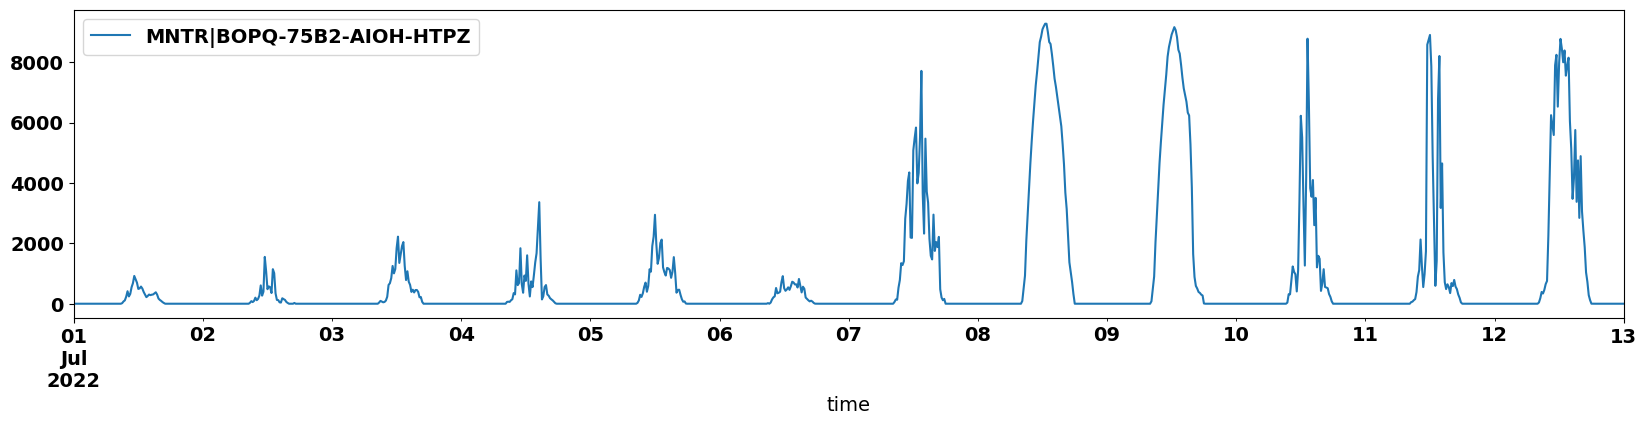

In [39]:

# df_5min.set_index('time').iloc[:, 0:10].plot(figsize=(24,3))
df_MID.loc[(df_MID['time']>='2022-07-01')&(df_MID['time']<='2022-07-13'), ['time', MID]].set_index('time').plot(figsize=(20, 4))


# 4 Calculate Clear-Sky Days

In [42]:
df_clearsky_sites = clearsky_cal(date_start=start_date, date_end=end_date)
df_clearsky_sites

,date,SITE|65e61db2-2bb3-4480-b495-96064d5ed331,SITE|4dddc226-3464-4c95-aded-875e490a2f02,SITE|d830cf82-d943-404a-8396-9b22141538a8,SITE|c9fcf61f-c1a9-48d8-b2bb-c843dbd69119,SITE|09640f46-ed55-45be-b243-dbbe126fc994,SITE|166b83a9-ad51-4ad2-b853-fdb1aa936f6d,SITE|d317a168-4257-4187-9603-3d4834532bbb,SITE|11fde49c-5cd0-429c-8013-97c9a1c1462d,SITE|d159d534-3a20-4bce-9df0-5772d555d4c8,...,SITE|75493355-27b1-4676-91b8-dc598d46813b,SITE|bca93ed0-dcc7-4262-9bb0-320f25b0d93e,SITE|1b3255ea-c7ee-41c3-bfa1-b8748787de0c,SITE|14708719-4bec-45c7-8364-e3b765109de2,SITE|8ee3f4c9-483b-426a-bd77-2a7121b9bbcf,SITE|93dcd16f-e2e9-422c-9099-fa50c46998a5,SITE|ef7f758c-4612-4025-acc4-47cfec16891f,SITE|6577b77e-93fe-486b-bc95-b77c5ce6a18e,SITE|4229b257-cc70-4d03-8c0a-1f0d930d792e,SITE|49965a47-7a49-4866-a11f-06cb600ac967
1096,2022-01-01,NaN,True,NaN,True,NaN,NaN,True,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,True
1097,2022-01-02,NaN,True,NaN,True,NaN,NaN,True,NaN,NaN,...,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,False
1098,2022-01-03,NaN,True,NaN,True,NaN,NaN,True,NaN,NaN,...,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True
1099,2022-01-04,NaN,True,NaN,True,NaN,NaN,False,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,True
1100,2022-01-05,NaN,False,NaN,False,NaN,NaN,False,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,2023-08-26,True,True,False,True,NaN,NaN,NaN,True,False,...,True,True,True,True,True,True,NaN,NaN,NaN,True
1699,2023-08-27,True,True,True,True,NaN,NaN,NaN,True,True,...,False,True,True,True,False,False,NaN,NaN,NaN,True
1700,2023-08-28,True,True,False,True,NaN,NaN,NaN,True,True,...,True,True,True,True,True,True,NaN,NaN,NaN,True
1701,2023-08-29,True,True,False,True,NaN,NaN,NaN,True,True,...,True,True,True,True,True,True,NaN,NaN,NaN,True


# 5 Preprocess and Prepare the Samples

In [43]:
df_timeslots = pd.DataFrame(index=range(timeslots_daily), columns=['time'])
df_timeslots['time'] = pd.date_range(start='2023-06-21 00:00:00', end='2023-06-21 23:59:59', freq='15min')
df_timeslots['time_str'] = df_timeslots['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_timeslots['hour_min'] = df_timeslots['time_str'].str.split(' ').str[-1]
df_timeslots['hour'] = df_timeslots['time'].dt.hour
df_effective_timeslots = df_timeslots
df_effective_timeslots.index=range(len(df_effective_timeslots))
df_effective_timeslots
# df_timeslots


,time,time_str,hour_min,hour
0,2023-06-21 00:00:00,2023-06-21 00:00:00,00:00:00,0
1,2023-06-21 00:15:00,2023-06-21 00:15:00,00:15:00,0
2,2023-06-21 00:30:00,2023-06-21 00:30:00,00:30:00,0
3,2023-06-21 00:45:00,2023-06-21 00:45:00,00:45:00,0
4,2023-06-21 01:00:00,2023-06-21 01:00:00,01:00:00,1
...,...,...,...,...
91,2023-06-21 22:45:00,2023-06-21 22:45:00,22:45:00,22
92,2023-06-21 23:00:00,2023-06-21 23:00:00,23:00:00,23
93,2023-06-21 23:15:00,2023-06-21 23:15:00,23:15:00,23
94,2023-06-21 23:30:00,2023-06-21 23:30:00,23:30:00,23


In [44]:
from statsmodels.tsa.seasonal import STL
# ========================================================
# = smooth the profile with stl
# ========================================================
def STL_trend(time_series):
    stl = STL(time_series, period=10)
    result = stl.fit()
    trend = result.trend
    return trend

In [45]:
# ========================================================
# = increase the samples by adding noise to generate new samples
# ========================================================
def add_noise(y_true):
    max_value = np.max(y_true)
    noise = np.random.uniform(0, 0.02*max_value, len(y_true))
    y_noisy = y_true + noise
    return y_noisy

In [46]:
# ========================================================
# = create a singl sample
# ========================================================
def create_single_sample(df_ml_raw, power_value, norm_method, mean_value, std_value, max_value, clearsky_dict, dateid, dcPvsize, faultid, faultname, midname):
    clearsky_or_not = clearsky_dict[dateid]
    if norm_method == 'Standar':
        power_norm = (power_value - mean_value) / std_value
    else:
        power_norm = (power_value) / max_value
    
    value_list = [dateid] + power_value.tolist() + [dcPvsize, faultid, faultname, midname, clearsky_or_not, mean_value, std_value, max_value]
    value_norm_list = [dateid] + power_norm.tolist() + [dcPvsize, faultid, faultname, midname, clearsky_or_not, mean_value, std_value, max_value]
    # calculate the STL trend
    trend = STL_trend(time_series=power_value)
    value_stl_list = [dateid] + trend.tolist() + [dcPvsize, faultid, faultname, midname, clearsky_or_not, mean_value, std_value, max_value]
    
    # calculate the normalize stl trend
    trend_norm = STL_trend(time_series=power_norm)
    normvalue_stl_list = [dateid] + trend.tolist() + [dcPvsize, faultid, faultname, midname, clearsky_or_not, mean_value, std_value, max_value]

    new_row_raw = {}
    new_row_norm = {}
    new_row_stl = {}
    new_row_normstl = {}
    for j, col in enumerate(df_ml_raw.columns.to_list()):
        new_row_raw[col] = value_list[j]
        new_row_norm[col] = value_norm_list[j]
        new_row_stl[col] = value_stl_list[j]
        new_row_normstl[col] = normvalue_stl_list[j]
    return new_row_raw, new_row_norm, new_row_stl, new_row_normstl

In [97]:
# ========================================================
# = each row in the labelling table has multiple days
# ========================================================
def samples_row_label(df_row, df, df_ml_raw, df_ml_normalized, df_ml_stl, df_ml_stl_norm, norm_method):
    mid = str(df_row['diagnoId'])
    # name and parameters
    midname = 'MNTR|' + mid
    print(midname)
    site_id = str(df_row['siteId'])
    print('site_id:', site_id)
    dcPvsize = df_row['dcSize']*1000
    print('PV size:', dcPvsize)
    ## ===== find the date list with faults
    faultid, faultname = df_row[['faultCode', 'faultName']]
    print(faultid, faultname)
    mid_date_start, mid_date_end = df_row[['faultStartdate', 'faultEnddate']]
    if isinstance(mid_date_end, str):
        # Convert the string to a datetime object
        mid_date_end = datetime.datetime.strptime(mid_date_end, "%Y-%m-%d") 
    # print('date_end:', mid_date_end, type(mid_date_end))
    # Add one day to the datetime object
    mid_date_end = mid_date_end + datetime.timedelta(days=1)
    # Convert the result back to a string
    mid_date_end = mid_date_end.strftime("%Y-%m-%d")
    date_list = pd.date_range(start=mid_date_start, end=mid_date_end).strftime('%Y-%m-%d').values.tolist()

    # # mark clear-sky days # there is no clear-sky/expected generation in the database
    # print('==== find clearsky days =====')
    clearsky_dict = select_clearsky_days(date_list=date_list, df_clearday_sites=df_clearsky_sites, site_id=site_id)
    print(clearsky_dict)
    ## read raw data
    if (midname in df.columns.to_list()) and (clearsky_dict != None):
        df_mid = df[['time', midname]].copy()
        # df_mid['date'] = df_mid['time'].dt.date
        # df_mid.loc[df_mid['date']==df_mid['date'].values[0], ['time', midname]].set_index('time').plot(figsize=(20, 4))
        df_mid['hour'] = df_mid['time'].dt.hour
        if len(df_mid)!=0:
            # if not (df_mid.loc[(df_mid['hour']>22) | (df_mid['hour']<4), midname]==0).all():
            #     print('there is time zone issue')
            # else:
            # #========= processing the data
            df_mid['date'] = df_mid['time'].dt.date
            df_mid['hour'] = df_mid['time'].dt.hour
            df_mid['date'] = pd.to_datetime(df_mid['date']).dt.strftime('%Y-%m-%d')
            df_mid.index = np.arange(len(df_mid))
            df_mid = preprocess_data(df=df_mid, MID=midname, effective_start_time=effective_start_time, effective_end_time=effective_end_time, pvsize=dcPvsize)
            # calculate mean and variance
            mean_value, std_value = calculate_mean_variance(df_mid[midname].values)
            print('mean:{}, std_deviation: {}'.format(mean_value, std_value))
            max_value = df_mid[midname].max()
            print('maximum value :{}'.format(max_value))

            ## each day for a sample
            for dateid in date_list:
                power_value = df_mid.loc[df_mid['date']==dateid, midname].values
                ## there are too less normal examples, increase it by adding noise 
                if (len(power_value)!=0):
                    ## === use maximum and minimum values for normalization
                    # power_norm = power_value/maxvalue
                    ## === use mean and variance values for normalization
                    new_row_raw, new_row_norm, new_row_stl, new_row_normstl = create_single_sample(df_ml_raw, power_value, norm_method, mean_value, std_value, max_value, clearsky_dict, dateid, dcPvsize, faultid, faultname, midname)
                    df_ml_raw = df_ml_raw.append(new_row_raw, ignore_index=True)
                    df_ml_normalized = df_ml_normalized.append(new_row_norm, ignore_index=True)
                    df_ml_stl = df_ml_stl.append(new_row_stl, ignore_index=True)
                    df_ml_stl_norm = df_ml_stl_norm.append(new_row_normstl, ignore_index=True)
                    # if faultname == 'Exemplar Data AC':
                    #     for sam in range(noise_num):
                    #         power_noise = add_noise(y_true=power_value)
                    #         new_row_raw, new_row_norm, new_row_stl, new_row_normstl = create_single_sample(power_value, norm_method, mean_value, std_value, max_value, clearsky_dict, dateid, dcPvsize, faultid, faultname, midname)
                    #         df_ml_raw = df_ml_raw.append(new_row_raw, ignore_index=True)
                    #         df_ml_normalized = df_ml_normalized.append(new_row_norm, ignore_index=True)
                    #         df_ml_stl = df_ml_stl.append(new_row_stl, ignore_index=True)
                    #         df_ml_stl_norm = df_ml_stl_norm.append(new_row_normstl, ignore_index=True)
    return df_ml_raw, df_ml_normalized, df_ml_stl, df_ml_stl_norm

In [98]:
# ========================================================
# = For the training samples
# ========================================================
df_trraw = pd.DataFrame(columns=['date'] + df_effective_timeslots['hour_min'].values.tolist() + ['dcPvsize', 'faultID', 'faultname', 'MID', 'ClearSky', 'Mean_value', 'Std_value', 'Max_value'])
df_trnormalized = pd.DataFrame(columns=['date'] + df_effective_timeslots['hour_min'].values.tolist() + ['dcPvsize', 'faultID', 'faultname', 'MID', 'ClearSky', 'Mean_value', 'Std_value', 'Max_value'])
df_trstl = pd.DataFrame(columns=['date'] + df_effective_timeslots['hour_min'].values.tolist() + ['dcPvsize', 'faultID', 'faultname', 'MID', 'ClearSky', 'Mean_value', 'Std_value', 'Max_value'])
df_trstl_norm = pd.DataFrame(columns=['date'] + df_effective_timeslots['hour_min'].values.tolist() + ['dcPvsize', 'faultID', 'faultname', 'MID', 'ClearSky', 'Mean_value', 'Std_value', 'Max_value'])
norm_method = 'Standar'

for i in range(len(df_trlabel_concern)):
    df_row = df_trlabel_concern.iloc[i, :]
    print('='*20)
    df_trraw, df_trnormalized, df_trstl, df_trstl_norm = samples_row_label(df_row=df_row,  df=df, df_ml_raw=df_trraw , df_ml_normalized=df_trnormalized, df_ml_stl=df_trstl, df_ml_stl_norm=df_trstl_norm, norm_method=norm_method)

MNTR|b4966e42-a8de-4613-9278-51071068521d
site_id: 692d1b44-f917-4a8f-b9a2-09c77e38f3b2
PV size: 20550.0
L1F004 Recurring Underperformance
{'2023-01-01': True, '2023-01-02': True, '2023-01-03': True, '2023-01-04': True, '2023-01-05': True, '2023-01-06': True, '2023-01-07': True, '2023-01-08': True, '2023-01-09': True, '2023-01-10': True, '2023-01-11': True, '2023-01-12': True, '2023-01-13': True, '2023-01-14': True, '2023-01-15': True, '2023-01-16': True, '2023-01-17': True, '2023-01-18': True, '2023-01-19': True, '2023-01-20': True, '2023-01-21': True, '2023-01-22': True, '2023-01-23': True, '2023-01-24': True, '2023-01-25': True, '2023-01-26': True, '2023-01-27': True, '2023-01-28': True, '2023-01-29': True, '2023-01-30': True, '2023-01-31': True, '2023-02-01': True, '2023-02-02': True, '2023-02-03': True, '2023-02-04': False, '2023-02-05': True}
mean:10378.896483161427, std_deviation: 5785.980070997238
maximum value :19993.0
MNTR|2bb0a158-2b9b-4cc8-b6be-91874cfde7aa
site_id: d20447e

In [99]:
# ========================================================
# = For the testing samples
# ========================================================
df_ttraw = pd.DataFrame(columns=['date'] + df_effective_timeslots['hour_min'].values.tolist() + ['dcPvsize', 'faultID', 'faultname', 'MID', 'ClearSky', 'Mean_value', 'Std_value', 'Max_value'])
df_ttnormalized = pd.DataFrame(columns=['date'] + df_effective_timeslots['hour_min'].values.tolist() + ['dcPvsize', 'faultID', 'faultname', 'MID', 'ClearSky', 'Mean_value', 'Std_value', 'Max_value'])
df_ttstl = pd.DataFrame(columns=['date'] + df_effective_timeslots['hour_min'].values.tolist() + ['dcPvsize', 'faultID', 'faultname', 'MID', 'ClearSky', 'Mean_value', 'Std_value', 'Max_value'])
df_ttstl_norm = pd.DataFrame(columns=['date'] + df_effective_timeslots['hour_min'].values.tolist() + ['dcPvsize', 'faultID', 'faultname', 'MID', 'ClearSky', 'Mean_value', 'Std_value', 'Max_value'])

for i in range(len(df_ttlabel_concern)):
    df_row = df_ttlabel_concern.iloc[i, :]
    print('='*20)
    df_ttraw, df_ttnormalized, df_ttstl, df_ttstl_norm = samples_row_label(df_row=df_row, df=df, df_ml_raw=df_ttraw , df_ml_normalized=df_ttnormalized, df_ml_stl=df_ttstl, df_ml_stl_norm=df_ttstl_norm, norm_method=norm_method)

MNTR|987654359
site_id: 5402940
PV size: 26100.0
L1F004 Recurring Underperformance
There is no data in the downloaded file for clear-sky days
None
MNTR|987654361
site_id: 4489810
PV size: 16000.0
L1F004 Recurring Underperformance
There is no data in the downloaded file for clear-sky days
None
MNTR|Z23P-Q4S3-Y75B-RGGS
site_id: 48053c86-8cb3-44e3-8647-0af3bde8bab9
PV size: 2160.0
L1F004 Recurring Underperformance
{'2022-06-06': True, '2022-06-07': True, '2022-06-08': True, '2022-06-09': True, '2022-06-10': True, '2022-06-11': True, '2022-06-12': True, '2022-06-13': True, '2022-06-14': True, '2022-06-15': True, '2022-06-16': True}
mean:410.23712195962344, std_deviation: 419.71532123701695
maximum value :1655.3333333333333
MNTR|793032
site_id: 6d04bfc5-ac77-462a-b0d4-9c58e472c5e2
PV size: 35910.0
L1F004 Recurring Underperformance
{'2023-03-16': True, '2023-03-17': True, '2023-03-18': True, '2023-03-19': True, '2023-03-20': True, '2023-03-21': False, '2023-03-22': False}
mean:1641.709143335

In [91]:
# df_trraw.to_csv('dataset/preprocessed/train_daily_recurring_clipping_normal.csv', index=None)
# df_ttraw.to_csv('dataset/preprocessed/test_daily_recurring_clipping_normal.csv', index=None)
# df_trnormalized.to_csv('dataset/preprocessed/stdnorm_train_daily_recurring_clipping_normal.csv', index=None)
# df_ttnormalized.to_csv('dataset/preprocessed/stdnorm_test_daily_recurring_clipping_normal.csv', index=None)

In [100]:
print('============= training samples ==========')
print('Recurring underperformance:', len(df_trraw[df_trraw['faultname']==concern_classes_list[0]]))
print('Clipping:', len(df_trraw[df_trraw['faultname']==concern_classes_list[1]]))
print('Normal:', len(df_trraw[df_trraw['faultname']==concern_classes_list[-1]]))
print('Total:', len(df_trraw))
print('============= testing samples ==========')
print('Recurring underperformance:', len(df_ttraw[df_ttraw['faultname']==concern_classes_list[0]]))
print('Clipping:', len(df_ttraw[df_ttraw['faultname']==concern_classes_list[1]]))
print('Normal:', len(df_ttraw[df_ttraw['faultname']==concern_classes_list[-1]]))
print('Total:', len(df_ttraw))

============= training samples ==========
Recurring underperformance: 560
Clipping: 278
Normal: 49
Total: 887
============= testing samples ==========
Recurring underperformance: 69
Clipping: 80
Normal: 0
Total: 149


80


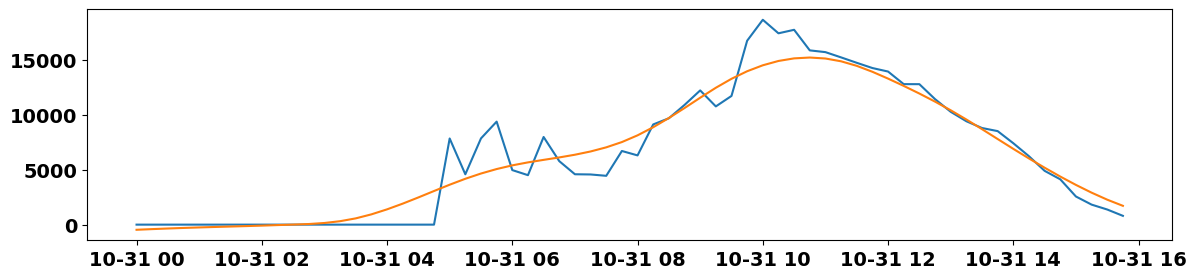

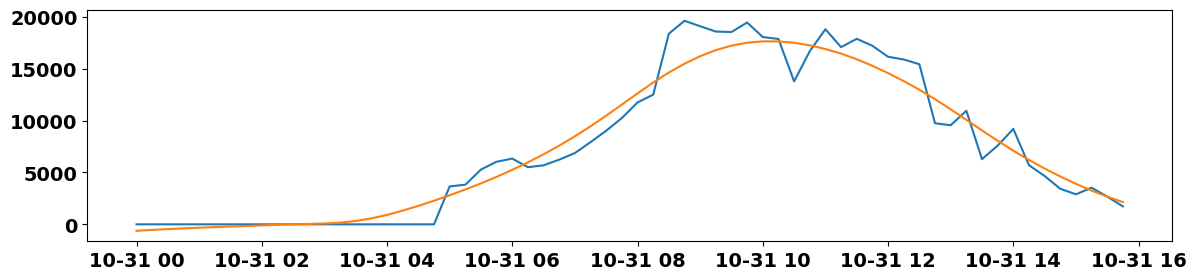

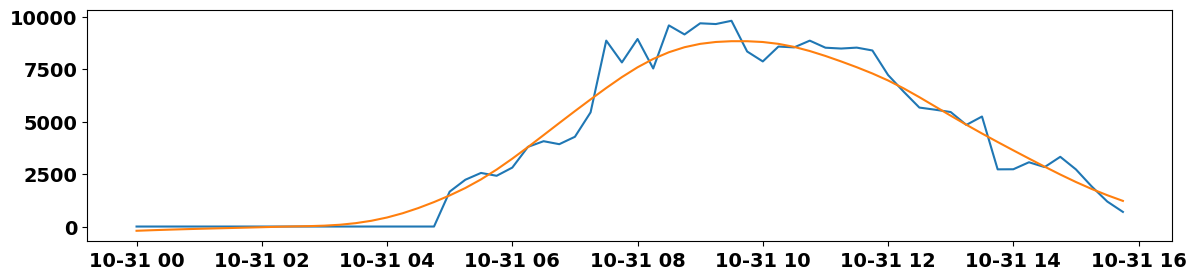

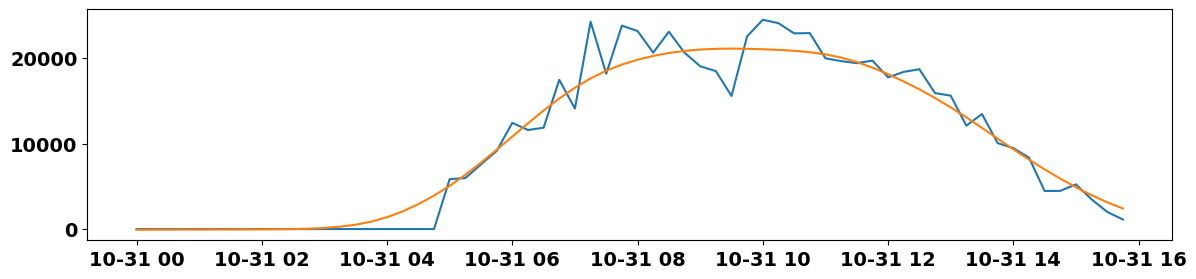

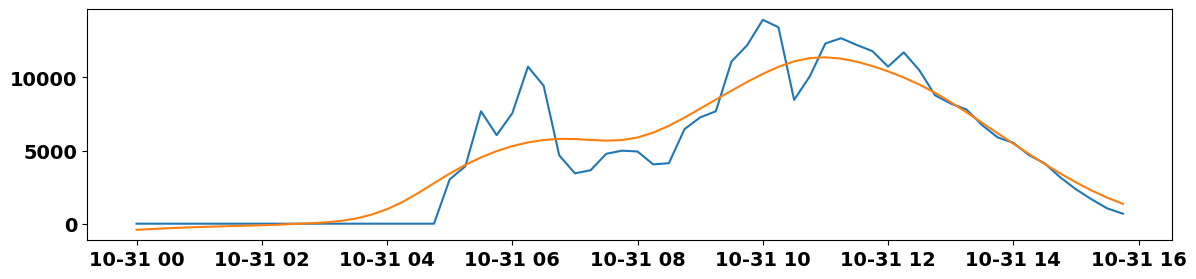

In [105]:
a = df_trraw[df_trraw['ClearSky']==False]
print(len(a))
date_strings = df_trraw.columns.to_list()[1:65]
datetime_objects = pd.to_datetime(date_strings)
for i, idx in enumerate(a.index[0:5]):
    fig, axes = plt.subplots(nrows=1, figsize=(14, 3))
    axes.plot(datetime_objects, df_trraw.iloc[idx, 1:65], label='raw')
    axes.plot(datetime_objects, df_trstl.iloc[idx, 1:65], label='stl')